In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
import statsmodels.api as sm 
import pylab as py

In [3]:
import nibabel as nib
import random

For a given couple of pipeline, we have 1000 group analyses. The function **voxel_concat** takes as input the parameter values for the first and the second pipeline, stores all the statistical values contained within the mask in a list for each of the 1000 group analyses, and returns a concatenation of the 1000 lists obtained.

Since the resulting list of voxels obtained is very large (more than 150M statistical values) and using it for further observations can be very time-consuming, we only take a random sample of 1M values. The function **save_sample** takes a vector and a file name as input and stores a random sample (fixed with a seed) within a .txt file.

To avoid having to execute *voxel_concat* (which can take a long time) each time we need to extract the sample values, and thus simplify the re-execution of the notebook, we will use a function **voxel_concat_sample**, which takes as input parameter values for both pipelines, uses *voxel_concat* and *save_sample* as auxiliary functions to create the random sample file only if it does not exists already, and reads and returns the file content when the file exists.

In [4]:
def voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2):
    Vect_vox=[]
    smooth1=str(smooth1)
    smooth2=str(smooth2)
    reg1=str(reg1)
    reg2=str(reg2)
    der1=str(der1)
    der2=str(der2)
    for i in range(1000):
        fold='SLA'+str(i+1)+'_50'
        V0 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'spmT_0001.nii')).get_data().flatten()
        V1 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'mask.nii')).get_data().flatten()
        V0bis=V0[V1!=0].tolist()
        Vect_vox=Vect_vox+V0bis
    return Vect_vox;

In [5]:
def save_sample(data,name):
    random.seed(0)
    data_sample=random.sample(data,1000000)
    
    sample_file = open(name+".txt","w")
    for i in range(1000000):
        sample_file.write(str(data_sample[i]))
        if i!=999999:
            sample_file.write(" \n")
    sample_file.close()

In [6]:
def voxel_concat_sample(smooth1,reg1,der1,smooth2,reg2,der2):
    
    if not(os.path.isfile('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt')):
        vect_vox1 = voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2)
        save_sample(vect_vox1,'sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2))
        
    with open('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt',"r") as V0:
        filecontents=V0.readlines()
    Vect_vox_sample=[float(i) for i in filecontents]
    return Vect_vox_sample;

In [7]:
def qqplot(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.show()

In [8]:
def qqplot1(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [9]:
def qqplot2(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.plot(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [10]:
def qqplot3(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    prop_quantile = [sum([i > 1- t/len(data) for i in dist.sf(np.array(data),98)])/len(data) for t in range(1,len(data)+1)]
    
    line1, = ax2.plot(p_th, prop_quantile, '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [29]:
def Bland_Altman(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    p_obs = sorted(dist.sf(np.array(data),98))
    
    ba_mean = [(p_th[i] + p_obs[i])/2 for i in range(len(data))]
    ba_diff = [(p_th[i] - p_obs[i]) for i in range(len(data))]
        
    line1, = ax2.plot(ba_mean, ba_diff,
                         label='Bland-Altman')
    ax2.set_title('Bland-Altman')
    plt.show()

# Tailles des masques

In [12]:
mask_size_list=[]

for i in range(1000):
    fold='SLA'+str(i+1)+'_50'
    V1 = nib.load(os.path.join('..', 'data',fold,'smooth_5_5','reg_6_6','der_1_1','mask.nii')).get_data().flatten()
    V1bis=V1[V1!=0].tolist()
    mask_size_list=mask_size_list+[len(V1bis)]

(array([  9.,  34.,  53.,  20.,  45.,  99., 193., 259., 237.,  51.]),
 array([129419. , 133370.7, 137322.4, 141274.1, 145225.8, 149177.5,
        153129.2, 157080.9, 161032.6, 164984.3, 168936. ]),
 <a list of 10 Patch objects>)

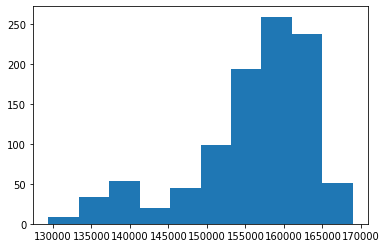

In [13]:
plt.hist(mask_size_list)

# Other Pairs of Pipelines

## Vector definitions

In [14]:
Vect_vox_561_500_sample = voxel_concat_sample(5,6,1,5,0,0);

In [15]:
Vect_vox_561_501_sample = voxel_concat_sample(5,6,1,5,0,1);

In [16]:
Vect_vox_561_560_sample = voxel_concat_sample(5,6,1,5,6,0);

In [17]:
Vect_vox_561_561_sample = voxel_concat_sample(5,6,1,5,6,1);

In [18]:
Vect_vox_561_5240_sample = voxel_concat_sample(5,6,1,5,24,0);

In [19]:
Vect_vox_561_5241_sample = voxel_concat_sample(5,6,1,5,24,1);

In [20]:
Vect_vox_561_800_sample = voxel_concat_sample(5,6,1,8,0,0);

In [21]:
Vect_vox_561_801_sample = voxel_concat_sample(5,6,1,8,0,1);

In [22]:
Vect_vox_561_860_sample = voxel_concat_sample(5,6,1,8,6,0);

In [23]:
Vect_vox_561_861_sample = voxel_concat_sample(5,6,1,8,6,1);

In [24]:
Vect_vox_561_8240_sample = voxel_concat_sample(5,6,1,8,24,0);

In [25]:
Vect_vox_561_8241_sample = voxel_concat_sample(5,6,1,8,24,1);

## Q-Q Plots & Bland-Altman Plots

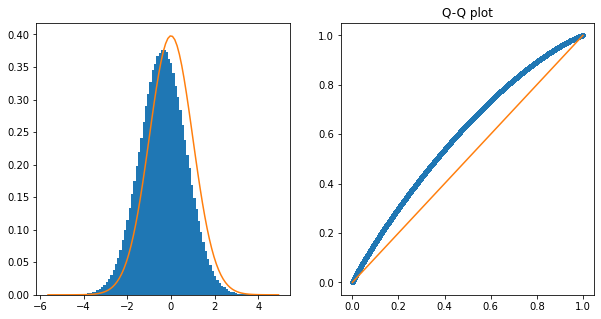

In [26]:
qqplot2(Vect_vox_561_500_sample,100)

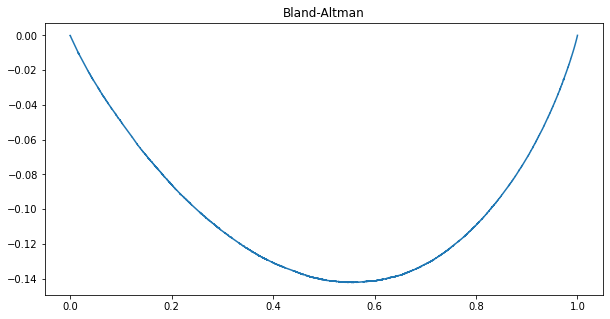

In [30]:
Bland_Altman(Vect_vox_561_500_sample)

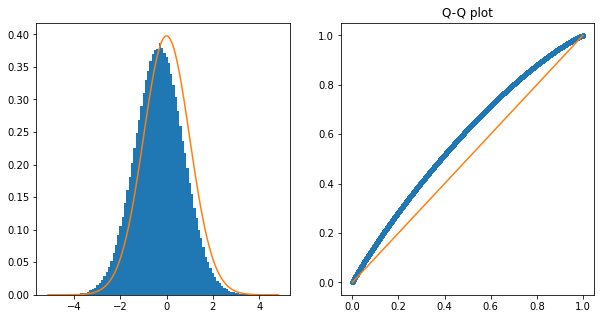

In [89]:
qqplot2(Vect_vox_561_501_sample,100)

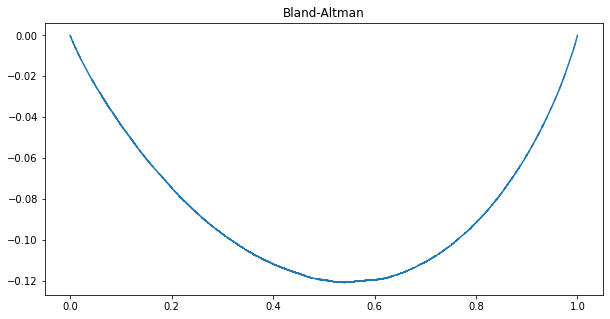

In [31]:
Bland_Altman(Vect_vox_561_501_sample)

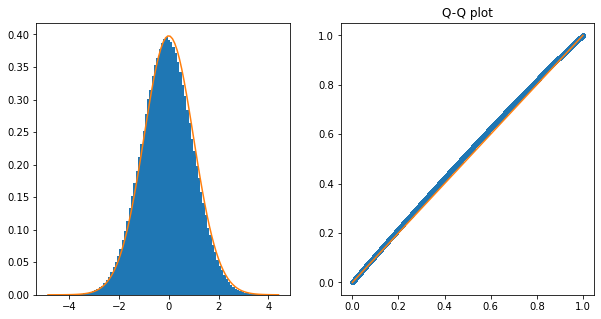

In [90]:
qqplot2(Vect_vox_561_560_sample,100)

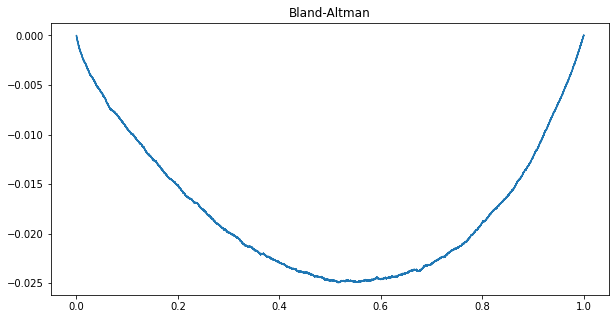

In [32]:
Bland_Altman(Vect_vox_561_560_sample)

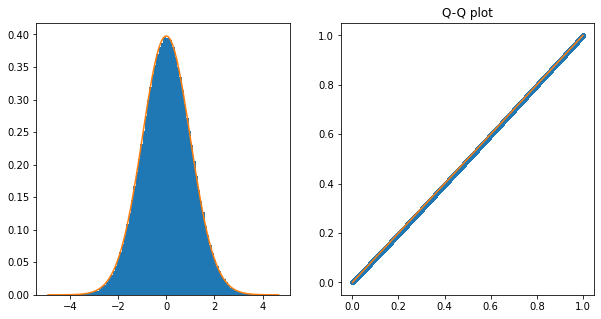

In [91]:
qqplot2(Vect_vox_561_561_sample,100)

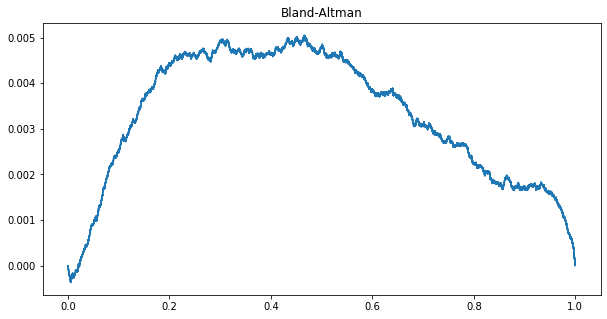

In [33]:
Bland_Altman(Vect_vox_561_561_sample)

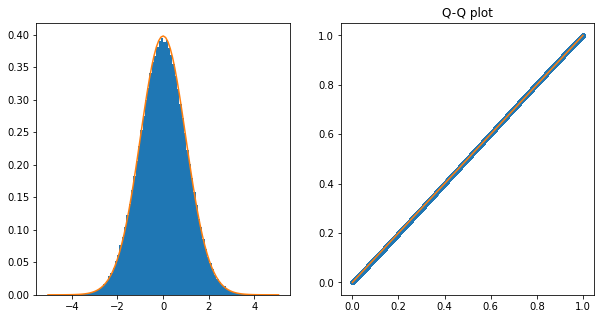

In [92]:
qqplot2(Vect_vox_561_5240_sample,100)

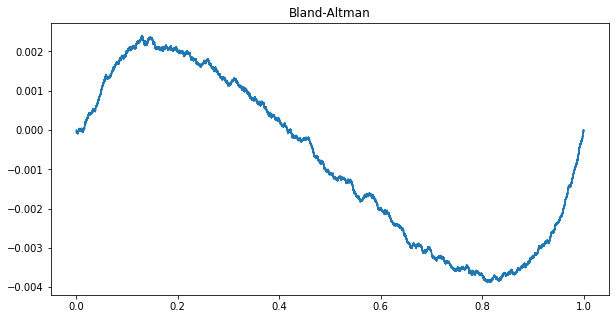

In [34]:
Bland_Altman(Vect_vox_561_5240_sample)

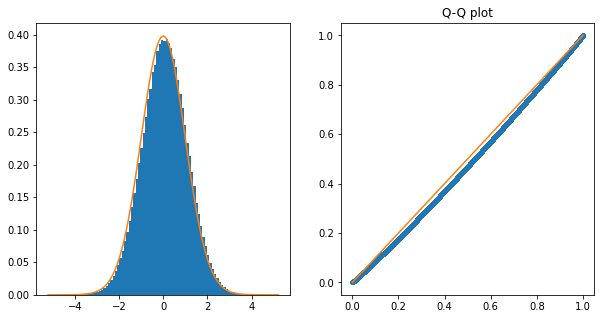

In [93]:
qqplot2(Vect_vox_561_5241_sample,100)

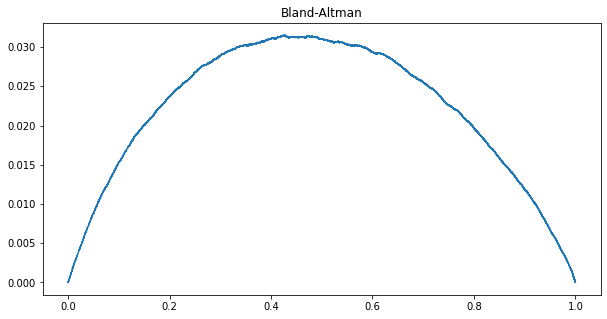

In [35]:
Bland_Altman(Vect_vox_561_5241_sample)

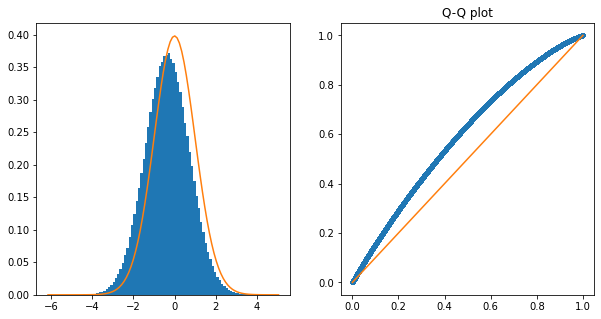

In [94]:
qqplot2(Vect_vox_561_800_sample,100)

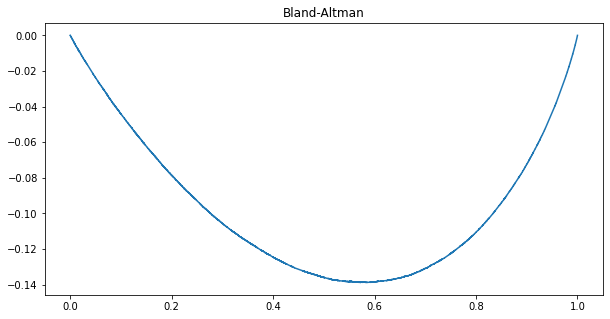

In [36]:
Bland_Altman(Vect_vox_561_800_sample)

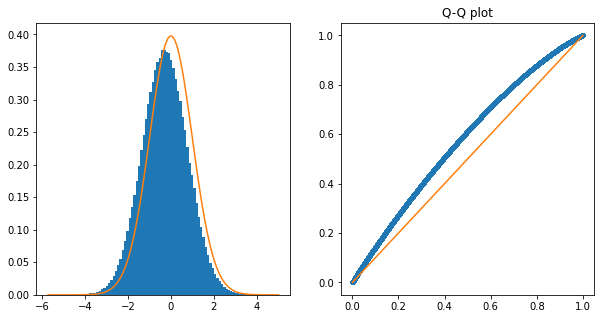

In [95]:
qqplot2(Vect_vox_561_801_sample,100)

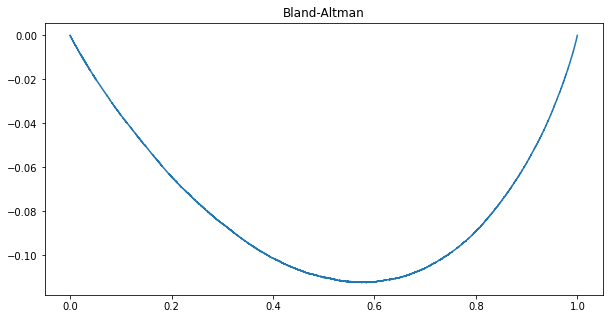

In [37]:
Bland_Altman(Vect_vox_561_801_sample)

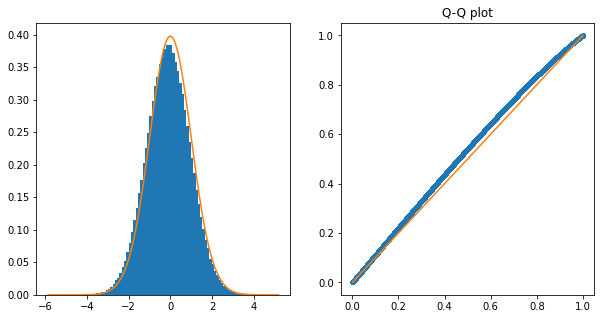

In [96]:
qqplot2(Vect_vox_561_860_sample,100)

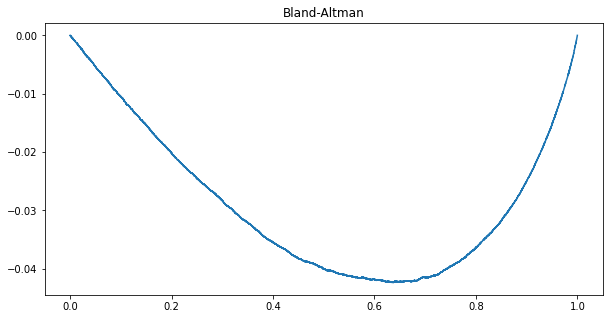

In [38]:
Bland_Altman(Vect_vox_561_860_sample)

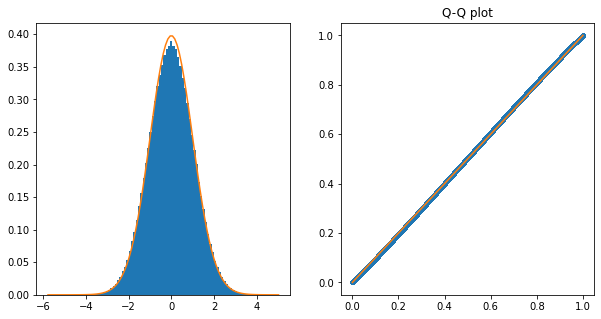

In [97]:
qqplot2(Vect_vox_561_861_sample,100)

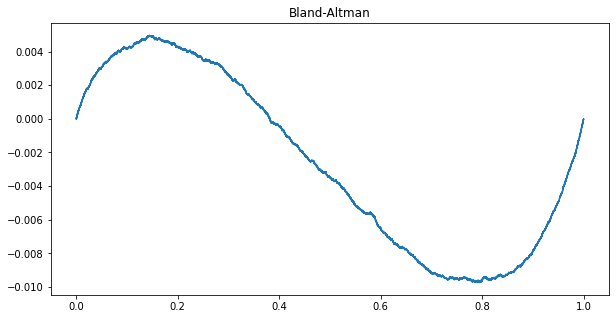

In [39]:
Bland_Altman(Vect_vox_561_861_sample)

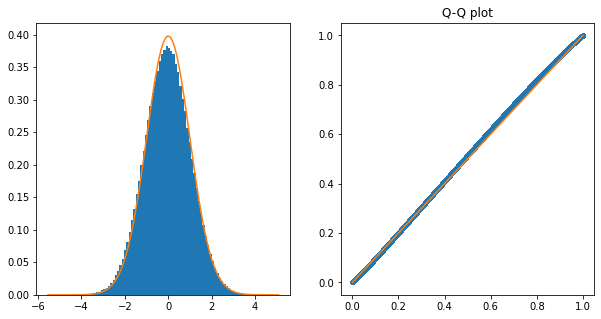

In [98]:
qqplot2(Vect_vox_561_8240_sample,100)

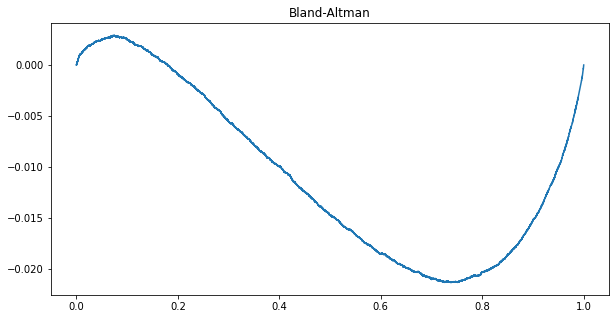

In [40]:
Bland_Altman(Vect_vox_561_8240_sample)

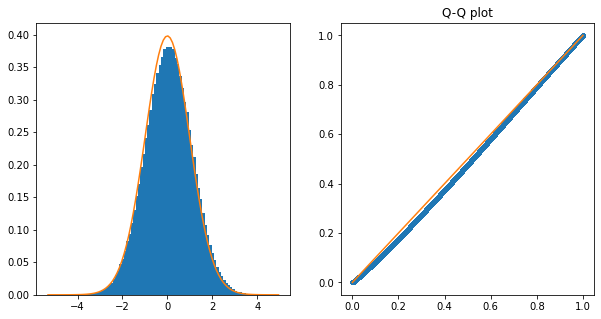

In [99]:
qqplot2(Vect_vox_561_8241_sample,100)

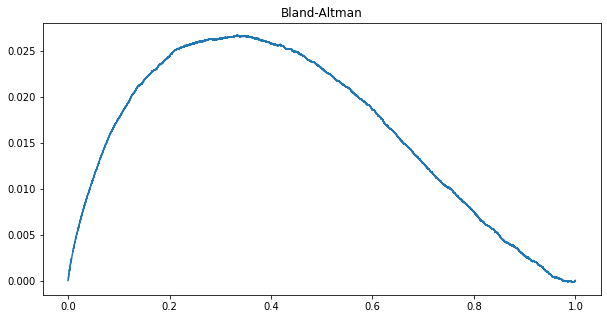

In [41]:
Bland_Altman(Vect_vox_561_8241_sample)